# **Exercise 1: Web Scraping, Portfolio Analysis & Visualization**

## **Part 1: Web Scraping Top Stock Gainers from Yahoo Finance**

### Installing Libraries and Calling Libraries

In [9]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import yfinance as yf

### Launch/Set the Driver

In [10]:
chrome_options = Options()
chrome_options.add_argument("--start-maximized")
driver = webdriver.Chrome(options=chrome_options)
url = "https://finance.yahoo.com/markets/stocks/gainers"
driver.get(url)
print("WebDriver iniciado con éxito:", driver.title)

WebDriver iniciado con éxito: Top Stock Gains: US stocks posting the highest gains today - Yahoo Finance


In [11]:
wait = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.TAG_NAME, "table"))
    )
print("Tabla encontrada. Comenzando el scraping.")

Tabla encontrada. Comenzando el scraping.


In [12]:
while True:
    try:
        show_more = wait.until(
            EC.element_to_be_clickable((By.XPATH, '/html/body/div[2]/main/section/section/section/section/section[1]/div/div[3]/div[1]/div/div/div/button/div/svg'))
        )
        driver.execute_script("arguments[0].click();", show_more)
        time.sleep(2)
    except:
        print("No hay más 'Show More'.")
        break

No hay más 'Show More'.


In [14]:
table = driver.find_element(By.TAG_NAME, "table")

rows = table.find_elements(By.TAG_NAME, "tr")

symbols = []
names = []

for row in rows[1:51]:
    cols = row.find_elements(By.TAG_NAME, "td")
    if len(cols) >= 2:
        symbols.append(cols[0].text.strip())
        names.append(cols[1].text.strip())

driver.quit()

In [15]:
stocks_df = pd.DataFrame({"Symbol": symbols, "Name": names})
print(stocks_df.head())
stocks_df.to_csv("top_50.csv", index=False, encoding='utf-8-sig')

  Symbol                   Name
0   REVG        REV Group, Inc.
1      M           Macy's, Inc.
2   TGTX  TG Therapeutics, Inc.
3  GOOGL          Alphabet Inc.
4   GOOG          Alphabet Inc.


## Part 2: Historical Data Retrieval

In [16]:
data = yf.download(
    tickers=symbols,
    period="1y",
    interval="1mo",
    group_by="ticker",
    auto_adjust=True,
    threads=True
)

[*********************100%***********************]  21 of 21 completed


In [17]:
adj_close = pd.DataFrame({sym: data[sym]["Close"] for sym in symbols})
print("\nAdjusted Close Prices:")
print(adj_close.head())


Adjusted Close Prices:
                 REVG          M       TGTX       GOOGL        GOOG  \
Date                                                                  
2024-10-01  26.367325  14.744837  25.059999  170.511078  172.091156   
2024-11-01  30.864695  15.609919  34.799999  168.358643  169.898788   
2024-12-01  31.710440  16.273149  30.100000  188.637436  189.779602   
2025-01-01  34.592140  15.137012  31.700001  203.538910  205.119476   
2025-02-01  30.405193  13.941984  30.090000  169.878448  171.817505   

                  SMR       PRKS        HMY       LYFT  SBSW  ...       IONS  \
Date                                                          ...              
2024-10-01  19.139999  52.630001  10.704062  12.970000  4.67  ...  38.389999   
2024-11-01  29.650000  58.639999   9.122093  17.360001  4.09  ...  35.730000   
2024-12-01  17.930000  56.189999   8.149335  12.900000  3.30  ...  34.959999   
2025-01-01  23.840000  52.560001  11.186725  13.540000  3.81  ...  31.900000  

## Part 3: Portfolio Construction & Analysis

In [18]:
first_half = adj_close.iloc[:6]
returns_first_half = first_half.pct_change().dropna()
accumulative_return = (1 + returns_first_half).prod() - 1

top10 = accumulative_return.sort_values(ascending=False).head(10).index.tolist()
print("\nTop 10 Selected Stocks:", top10)


Top 10 Selected Stocks: ['TGTX', 'HIMS', 'GENI', 'HMY', 'ALKS', 'REVG', 'HQY', 'SBSW', 'LYFT', 'GOOG']


In [19]:
second_half = adj_close.iloc[6:]
returns_second_half = second_half[top10].pct_change().dropna()
portfolio_returns = returns_second_half.mean(axis=1)


Portfolio Monthly Returns (last 6 months):
Date
2025-05-01    0.129008
2025-06-01    0.043965
2025-07-01    0.039211
2025-08-01   -0.015565
2025-09-01    0.086256
dtype: float64


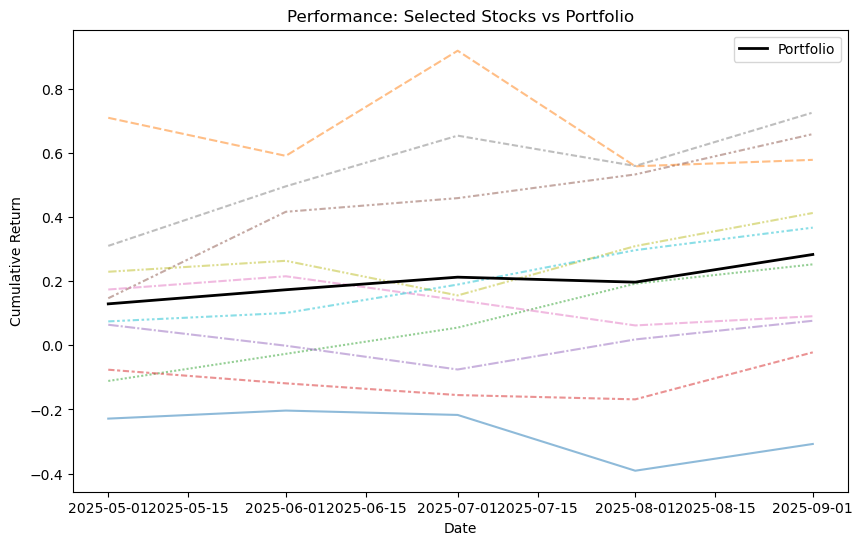

In [23]:
print("\nPortfolio Monthly Returns (last 6 months):")
print(portfolio_returns)

plt.figure(figsize=(10,6))
sns.lineplot(data=returns_second_half.cumsum(), legend=False, alpha=0.5)
sns.lineplot(x=portfolio_returns.index, y=portfolio_returns.cumsum(), label="Portfolio", color="black", linewidth=2)
plt.title("Performance: Selected Stocks vs Portfolio")
plt.ylabel("Cumulative Return")
plt.show()